In [29]:
import pandas as pd
import polars as pl
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from shapely.geometry import Point, Polygon
import geodatasets
import geopandas as gpd

In [2]:
vesselLabelsDF = pl.read_csv('fishing-vessels-v2.csv', infer_schema_length=10000)

In [3]:
vesselLabelsDF

mmsi,flag_ais,flag_registry,flag_gfw,vessel_class_inferred,vessel_class_inferred_score,vessel_class_registry,vessel_class_gfw,self_reported_fishing_vessel,length_m_inferred,length_m_registry,length_m_gfw,engine_power_kw_inferred,engine_power_kw_registry,engine_power_kw_gfw,tonnage_gt_inferred,tonnage_gt_registry,tonnage_gt_gfw,registries_listed,fishing_hours_2012,fishing_hours_2013,fishing_hours_2014,fishing_hours_2015,fishing_hours_2016,fishing_hours_2017,fishing_hours_2018,fishing_hours_2019,fishing_hours_2020
i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
40120000,"""NA""","""GRC""","""GRC""","""NA""","""NA""","""trawlers""","""trawlers""","""TRUE""","""NA""","""26.3""","""26.3""","""NA""","""176.4""","""176.4""","""NA""","""133""","""133""","""EU|GFCM|IMO""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""674.1"""
444002410,"""NA""","""KOR""","""KOR""","""NA""","""NA""","""tuna_purse_seines""","""tuna_purse_seines""","""FALSE""","""NA""","""79.6""","""79.6""","""NA""","""3256.29""","""3256.29""","""NA""","""2132.33""","""2132.33""","""FFA|IMO|ISSF|KOR|WCPFC|WCPFC2""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""144.43"""
987654320,"""NA""","""PHL""","""PHL""","""NA""","""NA""","""tuna_purse_seines""","""tuna_purse_seines""","""FALSE""","""NA""","""66.4""","""66.4""","""NA""","""2219.27""","""2219.27""","""NA""","""1081""","""1081""","""FFA|ISSF|WCPFC|WCPFC2""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""545.33"""
554128120,"""NA""","""NRU""","""NRU""","""NA""","""NA""","""tuna_purse_seines""","""tuna_purse_seines""","""FALSE""","""NA""","""71.79""","""71.79""","""NA""","""2647""","""2647""","""NA""","""1350""","""1350""","""FFA|IMO|ISSF|TWN4|WCPFC""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""587.01"""
112119600,"""NA""","""USA""","""USA""","""NA""","""NA""","""fishing""","""fishing""","""TRUE""","""NA""","""24.64""","""24.64""","""NA""","""NA""","""NA""","""NA""","""85.48""","""85.48""","""IMO|USA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""NA""","""318.22"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
601523000,"""ZAF""","""NA""","""ZAF""","""other_purse_seines""","""0.999""","""NA""","""other_purse_seines""","""TRUE""","""29.29""","""NA""","""29.29""","""367.53""","""NA""","""367.53""","""163.9""","""NA""","""163.9""","""NA""","""NA""","""NA""","""NA""","""225.17""","""248.62""","""276.68""","""268.53""","""138.34""","""309.7"""
601554000,"""ZAF""","""NA""","""ZAF""","""other_purse_seines""","""0.897""","""NA""","""other_purse_seines""","""TRUE""","""29.82""","""NA""","""29.82""","""362.61""","""NA""","""362.61""","""135.52""","""NA""","""135.52""","""NA""","""NA""","""26.35""","""133.38""","""89.45""","""220.58""","""168.56""","""80.66""","""186.25""","""313.66"""
601556000,"""ZAF""","""NA""","""ZAF""","""other_purse_seines""","""0.764""","""NA""","""other_purse_seines""","""TRUE""","""33.97""","""NA""","""33.97""","""625.19""","""NA""","""625.19""","""275.32""","""NA""","""275.32""","""NA""","""NA""","""61.26""","""87.62""","""154.18""","""155.5""","""217.7""","""140.74""","""203.67""","""220.57"""


In [4]:
#create primary flag field by using registry 1st and inferred 2nd
vesselLabelsDF = vesselLabelsDF.with_columns(
    pl.when(pl.col('flag_registry') != 'NA')
    .then(pl.col('flag_registry'))
    .otherwise(pl.col('flag_ais'))
    .alias('flag'))

vesselLabelsDF = vesselLabelsDF.with_columns(
    pl.when(pl.col('vessel_class_registry') != 'NA')
    .then(pl.col('vessel_class_registry'))
    .otherwise(pl.col('vessel_class_inferred'))
    .alias('class'))

In [5]:
#filter vessel labels DF for only needed fields
vesselLabelsDF = vesselLabelsDF[['mmsi', 'flag', 'class']]

In [6]:
vesselLabelsDF

mmsi,flag,class
i64,str,str
40120000,"""GRC""","""trawlers"""
444002410,"""KOR""","""tuna_purse_seines"""
987654320,"""PHL""","""tuna_purse_seines"""
554128120,"""NRU""","""tuna_purse_seines"""
112119600,"""USA""","""fishing"""
…,…,…
601523000,"""ZAF""","""other_purse_seines"""
601554000,"""ZAF""","""other_purse_seines"""
601556000,"""ZAF""","""other_purse_seines"""


In [7]:
#read in daily vessel location data
locRawDF = pl.read_csv('MMSI-daily-merged_2019_2020.csv')

In [8]:
#merge with labels DF to reference in flag and vessel class
locRawDF = locRawDF.join(vesselLabelsDF, on='mmsi', how='left')

In [9]:
locRawDF

date,cell_ll_lat,cell_ll_lon,mmsi,hours,fishing_hours,season,flag,class
str,f64,f64,i64,f64,f64,str,str,str
"""2019-01-01""",0.0,-105.6,224900000,0.2036,0.0,"""Winter""","""ESP""","""drifting_longlines"""
"""2019-01-01""",0.0,-105.3,224900000,0.0205,0.0,"""Winter""","""ESP""","""drifting_longlines"""
"""2019-01-01""",0.0,-105.5,224900000,0.9008,0.0,"""Winter""","""ESP""","""drifting_longlines"""
"""2019-01-01""",0.0,-105.4,224900000,0.8638,0.0,"""Winter""","""ESP""","""drifting_longlines"""
"""2019-01-01""",0.0,-0.3,228071900,0.7969,0.0,"""Winter""","""FRA""","""tuna_purse_seines"""
…,…,…,…,…,…,…,…,…
"""2020-12-31""",71.7,26.1,276842000,0.2108,0.0,"""Winter""","""EST""","""trawlers"""
"""2020-12-31""",75.7,16.0,273350610,0.1352,0.0,"""Winter""","""RUS""","""trawlers"""
"""2020-12-31""",75.7,15.9,273350610,0.3288,0.0,"""Winter""","""RUS""","""trawlers"""


In [10]:
#create unique vessel dataframe by removing all duplice mmsi's, regardless of date
uniqueVDF = locRawDF[['mmsi', 'flag', 'class']]
uniqueVDF = uniqueVDF.unique(subset=['mmsi'])

uniqueVesselCount = len(uniqueVDF)

#create flag count dataframe by counting unique flags and adding % of total field
flagCounts = uniqueVDF['flag'].value_counts()
flagCounts = flagCounts.with_columns((pl.col('count') / sum(flagCounts['count']) * 100).round(2).alias('pct'))

uniqueFlagCounts = len(flagCounts)

#aggregate all flag counts with less than 0.5% of total into an "other" category and re-run % of total
flagCounts = flagCounts.with_columns(pl.when(pl.col('pct') > 0.5)
                                     .then(pl.col('flag'))
                                     .otherwise(pl.lit('OTHER'))
                                     .alias('flag2'))

flagCounts = flagCounts[['count', 'flag2']]

flagCounts = (flagCounts.with_columns(pl.col('flag2')).group_by('flag2').sum())

flagCounts = flagCounts.with_columns((pl.col('count') / sum(flagCounts['count']) * 100).round(2).alias('pct'))
flagCounts = flagCounts.sort('pct', descending=True)

#create vessel class count dataframe by splitting and exploding vessel types, counting unique types, and adding % of total field
classCounts = (uniqueVDF.with_columns(pl.col('class').str.split('|'))
               .explode('class'))

classCounts = classCounts['class'].value_counts()
classCounts = classCounts.with_columns((pl.col('count') / sum (classCounts['count']) * 100).round(2).alias('pct'))
classCounts = classCounts.sort('pct', descending=True)

uniqueClassCounts = len(classCounts)

In [11]:
uniqueVesselCount, uniqueFlagCounts, uniqueClassCounts

(79481, 210, 18)

In [13]:
del locRawDF, flagCounts, classCounts, uniqueVesselCount, vesselLabelsDF

In [14]:
# Define data types for each column and load data
dtypes = {
    "date" : "str",
    "cell_ll_lat": "float32",
    "cell_ll_lon": "float32",
    "mmsi": "int32",
    "hours": "float32",
    "fishing_hours": "float32",
    "flag_registry": "category",
    "vessel_class_inferred": "category",
    "vessel_class_registry": "category",
    "vessel_class_gfw": "category",
    "vessel_class_inferred_score": "float32",
    "self_reported_fishing_vessel": "boolean",
    "length_m_inferred": "float32",
    "length_m_registry": "float32",
    "length_m_gfw": "float32",
    "engine_power_kw_inferred": "float32",
    "engine_power_kw_registry": "float32",
    "engine_power_kw_gfw": "float32",
    "tonnage_gt_inferred": "float32",
    "tonnage_gt_registry": "float32",
    "tonnage_gt_gfw": "float32",
    "fishing_hours_2019": "float32",
    "fishing_hours_2020": "float32"
}

df = pd.read_csv('MMSI-daily_merged_2019_2020-vessels-gfw-seasons.csv', dtype=dtypes)

In [15]:
df.head()

,date,cell_ll_lat,cell_ll_lon,mmsi,hours,fishing_hours,flag_registry,flag_gfw,vessel_class_inferred,vessel_class_inferred_score,...,length_m_gfw,engine_power_kw_inferred,engine_power_kw_registry,engine_power_kw_gfw,tonnage_gt_inferred,tonnage_gt_registry,tonnage_gt_gfw,fishing_hours_2019,fishing_hours_2020,season
0,2019-01-01,0.0,-105.599998,224900000,0.2036,0.0,ESP,ESP,drifting_longlines,0.987,...,32.77,555.359985,435.970001,435.970001,440.299988,398.029999,398.029999,2274.699951,832.679993,Winter
1,2019-01-01,0.0,-105.300003,224900000,0.0205,0.0,ESP,ESP,drifting_longlines,0.987,...,32.77,555.359985,435.970001,435.970001,440.299988,398.029999,398.029999,2274.699951,832.679993,Winter
2,2019-01-01,0.0,-105.500000,224900000,0.9008,0.0,ESP,ESP,drifting_longlines,0.987,...,32.77,555.359985,435.970001,435.970001,440.299988,398.029999,398.029999,2274.699951,832.679993,Winter
3,2019-01-01,0.0,-105.400002,224900000,0.8638,0.0,ESP,ESP,drifting_longlines,0.987,...,32.77,555.359985,435.970001,435.970001,440.299988,398.029999,398.029999,2274.699951,832.679993,Winter
4,2019-01-01,0.0,-0.300000,228071900,0.7969,0.0,FRA,FRA,tuna_purse_seines,0.982,...,77.00,3536.510010,3920.000000,3920.000000,2055.770020,2357.000000,2357.000000,1708.630005,1078.260010,Winter


In [16]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107207569 entries, 0 to 107207568
Data columns (total 25 columns):
 #   Column                        Dtype   
---  ------                        -----   
 0   date                          object  
 1   cell_ll_lat                   float32 
 2   cell_ll_lon                   float32 
 3   mmsi                          int32   
 4   hours                         float32 
 5   fishing_hours                 float32 
 6   flag_registry                 category
 7   flag_gfw                      object  
 8   vessel_class_inferred         category
 9   vessel_class_inferred_score   float32 
 10  vessel_class_registry         category
 11  vessel_class_gfw              category
 12  self_reported_fishing_vessel  boolean 
 13  length_m_inferred             float32 
 14  length_m_registry             float32 
 15  length_m_gfw                  float32 
 16  engine_power_kw_inferred      float32 
 17  engine_power_kw_registry      float32 
 18

In [17]:
# Count of nulls per column
null_counts = df.isnull().sum()
print('The total length of the dataset is', len(df))
print(null_counts)

The total length of the dataset is 107207569
date                                   0
cell_ll_lat                            0
cell_ll_lon                            0
mmsi                                   0
hours                                  0
fishing_hours                          0
flag_registry                   37786916
flag_gfw                          536901
vessel_class_inferred             416397
vessel_class_inferred_score       416397
vessel_class_registry           38490242
vessel_class_gfw                       0
self_reported_fishing_vessel        4893
length_m_inferred                 416397
length_m_registry               44173679
length_m_gfw                       63654
engine_power_kw_inferred          416397
engine_power_kw_registry        58932464
engine_power_kw_gfw               121350
tonnage_gt_inferred               416397
tonnage_gt_registry             41229283
tonnage_gt_gfw                     42841
fishing_hours_2019               4184254
fishing_hour

In [18]:
#Description
pd.set_option('display.float_format', '{:.2f}'.format)
df.describe()

,cell_ll_lat,cell_ll_lon,mmsi,hours,fishing_hours,vessel_class_inferred_score,length_m_inferred,length_m_registry,length_m_gfw,engine_power_kw_inferred,engine_power_kw_registry,engine_power_kw_gfw,tonnage_gt_inferred,tonnage_gt_registry,tonnage_gt_gfw,fishing_hours_2019,fishing_hours_2020
count,107207569.00,107207569.00,107207569.00,107207569.00,107207569.00,106791172.00,106791172.00,63033890.00,107143915.00,106791172.00,48275105.00,107086219.00,106791172.00,65978286.00,107164728.00,103023315.00,102117454.00
mean,25.80,34.61,382023417.78,2.98,0.96,0.86,34.93,40.44,34.77,763.06,1006.88,794.95,455.88,668.87,466.53,2033.05,2020.38
std,30.91,96.17,148902192.78,5.47,2.44,0.15,18.50,21.75,19.63,848.11,1167.94,973.63,763.35,1041.75,871.95,1786.80,1760.10
min,-77.90,-180.00,128.00,0.00,0.00,0.50,7.15,5.30,5.30,21.70,13.15,13.15,2.41,1.18,1.18,0.00,0.00
25%,4.70,-16.40,257205220.00,0.42,0.00,0.75,21.14,23.13,20.74,268.94,330.00,264.06,67.14,98.00,62.00,533.40,544.53
50%,34.60,19.90,412328683.00,0.80,0.00,0.93,27.57,36.00,27.05,442.76,660.00,442.99,152.45,329.00,141.38,1429.81,1432.07
75%,48.00,121.20,416639000.00,2.36,0.87,1.00,47.96,54.27,47.50,843.18,1044.40,869.00,501.44,747.87,499.00,3254.37,3203.70
max,81.70,179.90,1020002044.00,47.94,47.56,1.00,171.38,255.39,255.39,8090.11,16389.99,16389.99,9629.17,14055.00,14055.00,7584.20,8665.69


C:\Users\Zigma\AppData\Local\Temp\ipykernel_43604\315911948.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  country_fishing_hours_2019 = df.groupby('flag_registry')['fishing_hours_2019'].sum().reset_index()


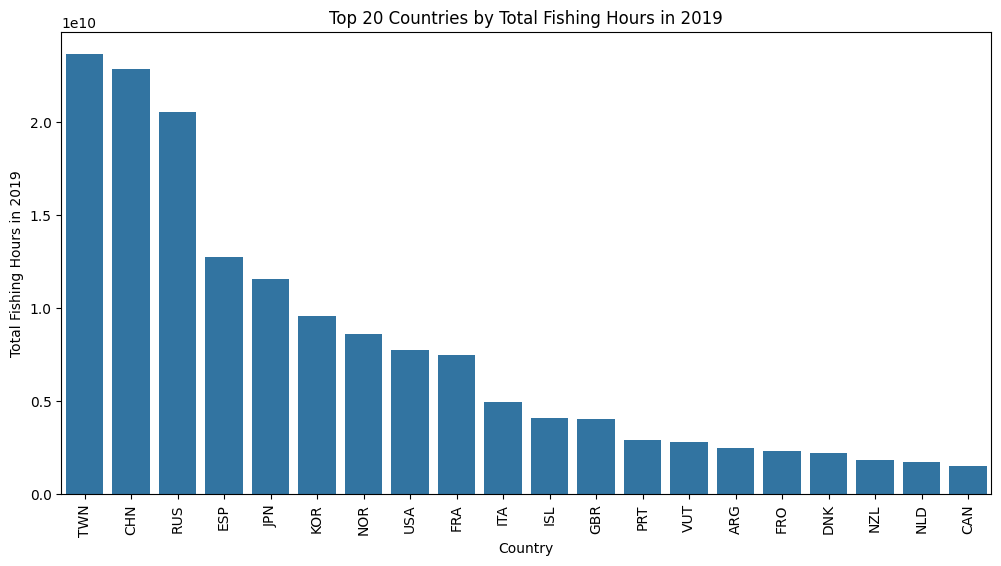

In [19]:
# Sum fishing hours by country for 2019
country_fishing_hours_2019 = df.groupby('flag_registry')['fishing_hours_2019'].sum().reset_index()

# Sort by fishing hours, top 20
top_20_countries_2019 = country_fishing_hours_2019.sort_values(by='fishing_hours_2019', ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x='flag_registry', y='fishing_hours_2019', data=top_20_countries_2019, 
            order=top_20_countries_2019.sort_values('fishing_hours_2019', ascending=False)['flag_registry'])
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Total Fishing Hours in 2019')
plt.title('Top 20 Countries by Total Fishing Hours in 2019')
plt.show()

C:\Users\Zigma\AppData\Local\Temp\ipykernel_43604\3733765597.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  country_fishing_hours_2020 = df.groupby('flag_registry')['fishing_hours_2020'].sum().reset_index()


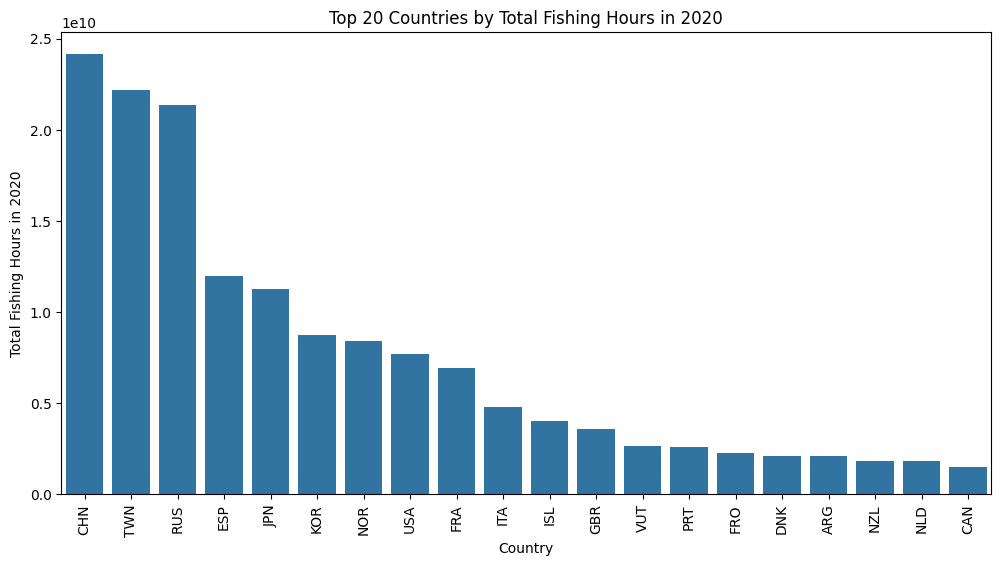

In [20]:
# Sum fishing hours by country for 2020
country_fishing_hours_2020 = df.groupby('flag_registry')['fishing_hours_2020'].sum().reset_index()

# Sort by fishing hours, top 20
top_20_countries_2020 = country_fishing_hours_2020.sort_values(by='fishing_hours_2020', ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x='flag_registry', y='fishing_hours_2020', data=top_20_countries_2020, 
            order=top_20_countries_2020.sort_values('fishing_hours_2020', ascending=False)['flag_registry'])
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Total Fishing Hours in 2020')
plt.title('Top 20 Countries by Total Fishing Hours in 2020')
plt.show()

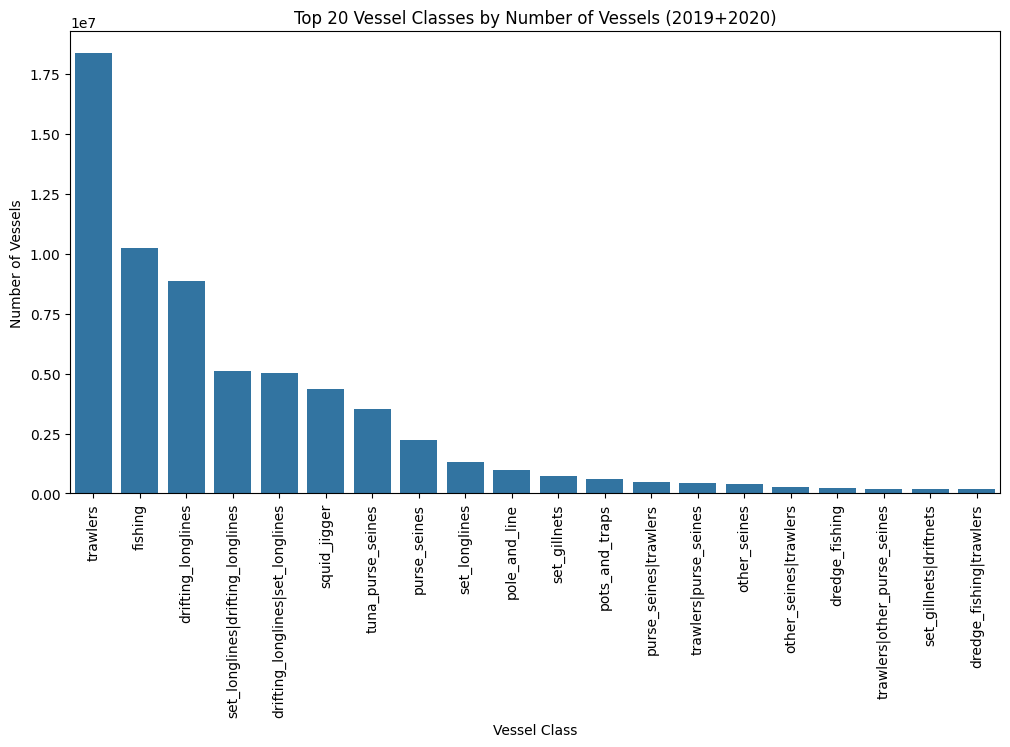

In [21]:
# Count number of vessels in each class
vessel_class_counts = df['vessel_class_registry'].value_counts().reset_index()
vessel_class_counts.columns = ['vessel_class_registry', 'count']

# Sort to top 20 types
top_20_vessel_classes = vessel_class_counts.sort_values(by='count', ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x='vessel_class_registry', y='count', data=top_20_vessel_classes, 
            order=top_20_vessel_classes['vessel_class_registry'])
plt.xticks(rotation=90)
plt.xlabel('Vessel Class')
plt.ylabel('Number of Vessels')
plt.title('Top 20 Vessel Classes by Number of Vessels (2019+2020)')
plt.show()

In [22]:
#Change format to Datetime
df['date'] = pd.to_datetime(df['date'])

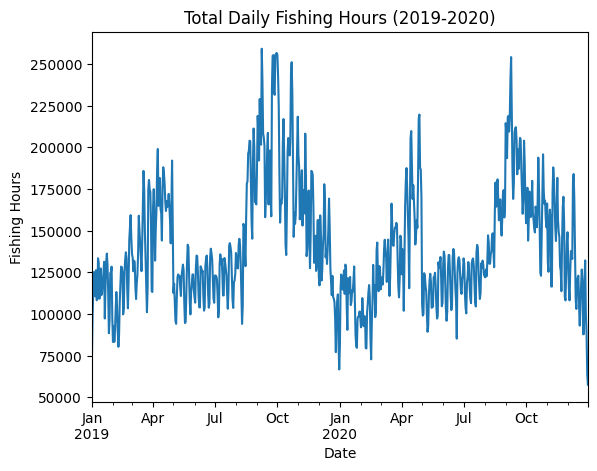

In [23]:
#Total Daily Fishing Hours Graph by Date

df.groupby('date')['fishing_hours'].sum().plot(kind='line')
plt.title('Total Daily Fishing Hours (2019-2020)')
plt.xlabel('Date')
plt.ylabel('Fishing Hours')
plt.show()

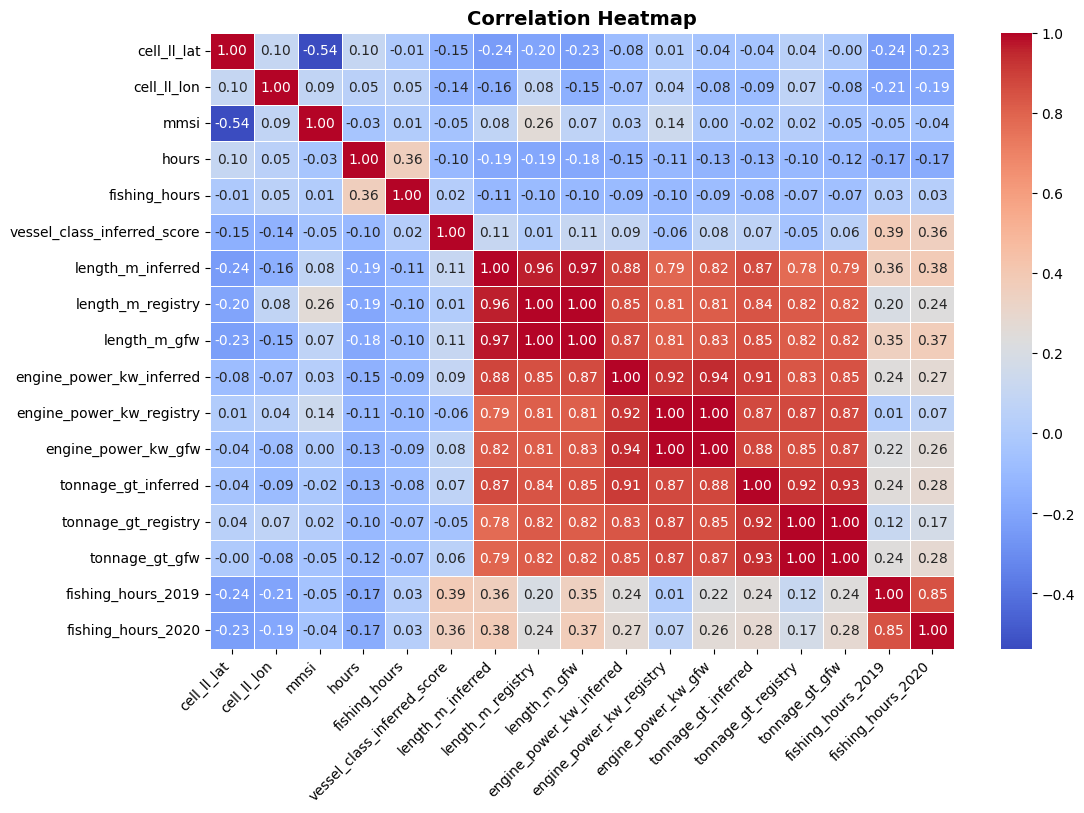

In [24]:
df_numeric = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
sns.heatmap(
    df_numeric.corr(), 
    annot=True, 
    cmap='coolwarm', 
    fmt='.2f', 
    linewidths=0.5,
    annot_kws={"size": 10}
)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.title("Correlation Heatmap", fontsize=14, fontweight="bold")

plt.show()

<Axes: title={'center': 'Total Fishing Hours by Season (2019-2020)'}, xlabel='season'>

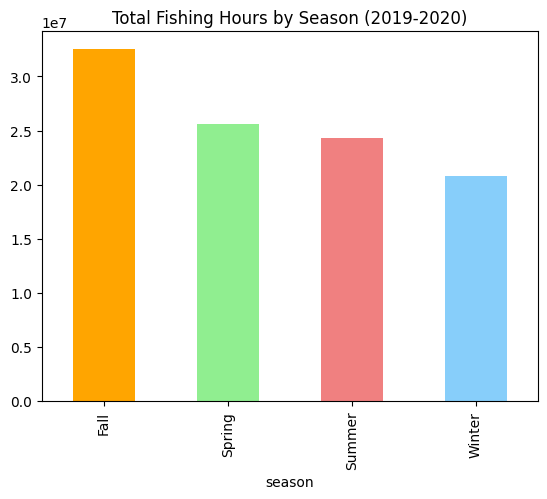

In [25]:
seasonal_fishing_hours = df.groupby('season')['fishing_hours'].sum()
seasonal_fishing_hours.plot(kind='bar', title='Total Fishing Hours by Season (2019-2020)', color=['orange', 'lightgreen', 'lightcoral', 'lightskyblue'])

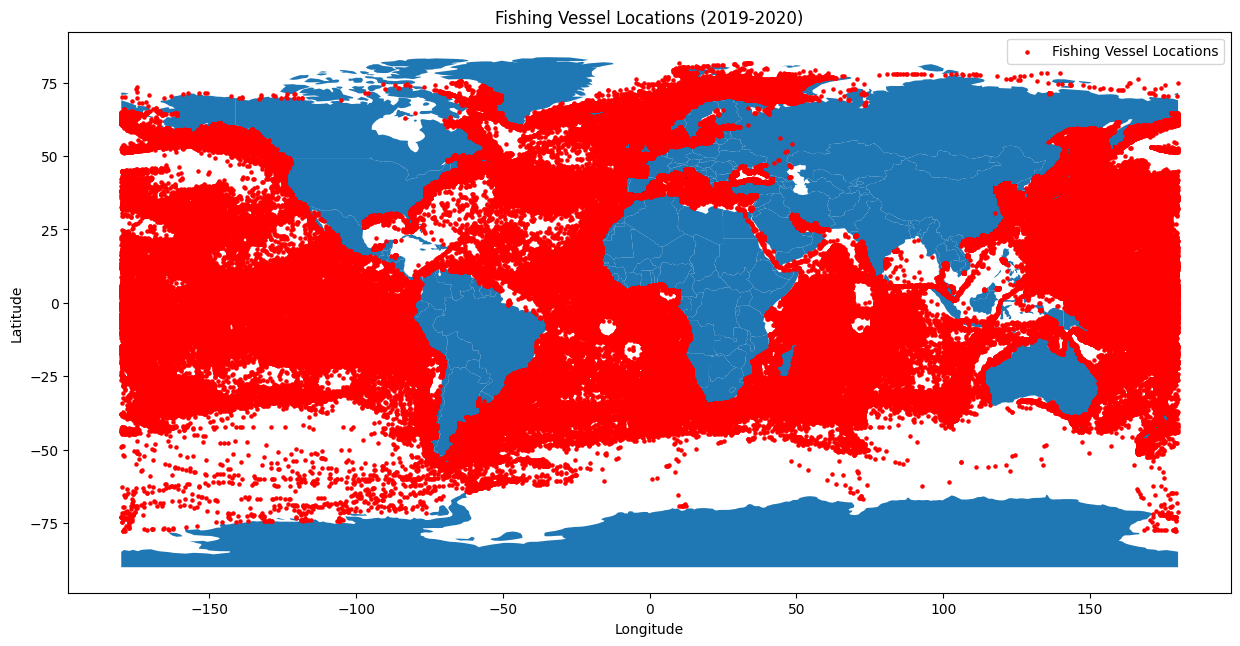

In [30]:
## All Data Sampled
sampled_df = df.sample(frac=0.01, random_state = 20)

geometry = [Point(lon, lat) for lon, lat in zip(sampled_df['cell_ll_lon'], sampled_df['cell_ll_lat'])]
gdf = gpd.GeoDataFrame(sampled_df, geometry=geometry)
gdf.set_crs("EPSG:4326", allow_override=True, inplace=True)

url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)

ax = world.plot(figsize=(15, 10))
gdf.plot(ax=ax, marker='o', color='red', markersize=5, label='Fishing Vessel Locations')

plt.title('Fishing Vessel Locations (2019-2020)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

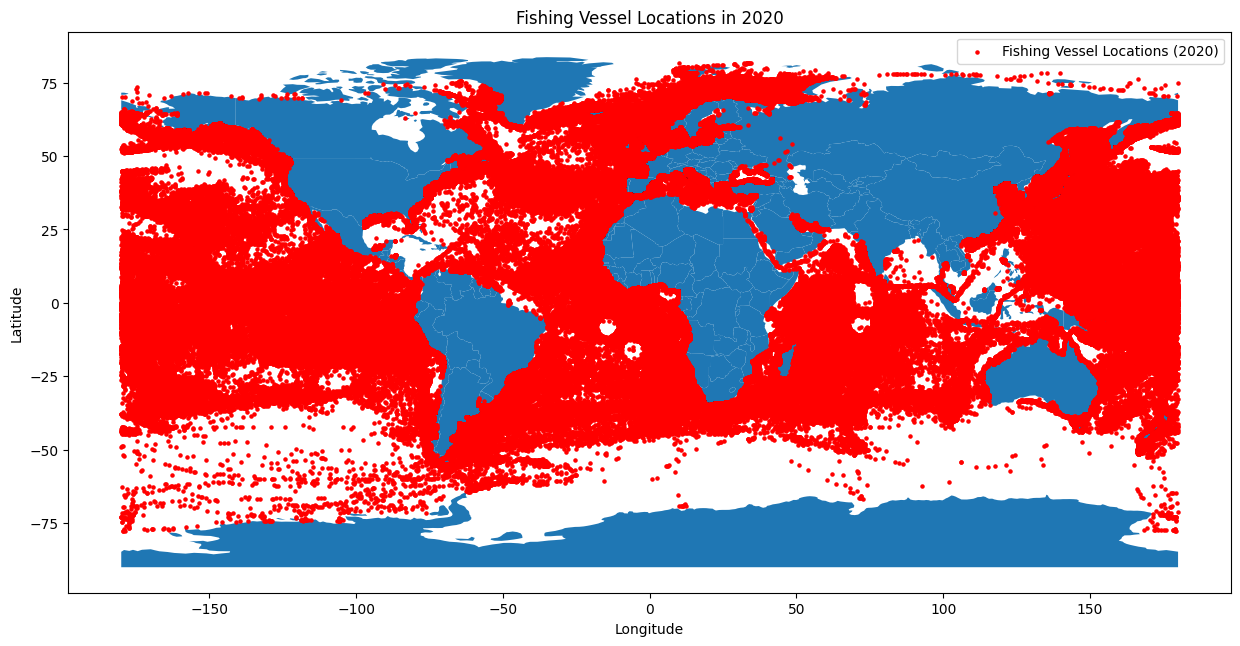

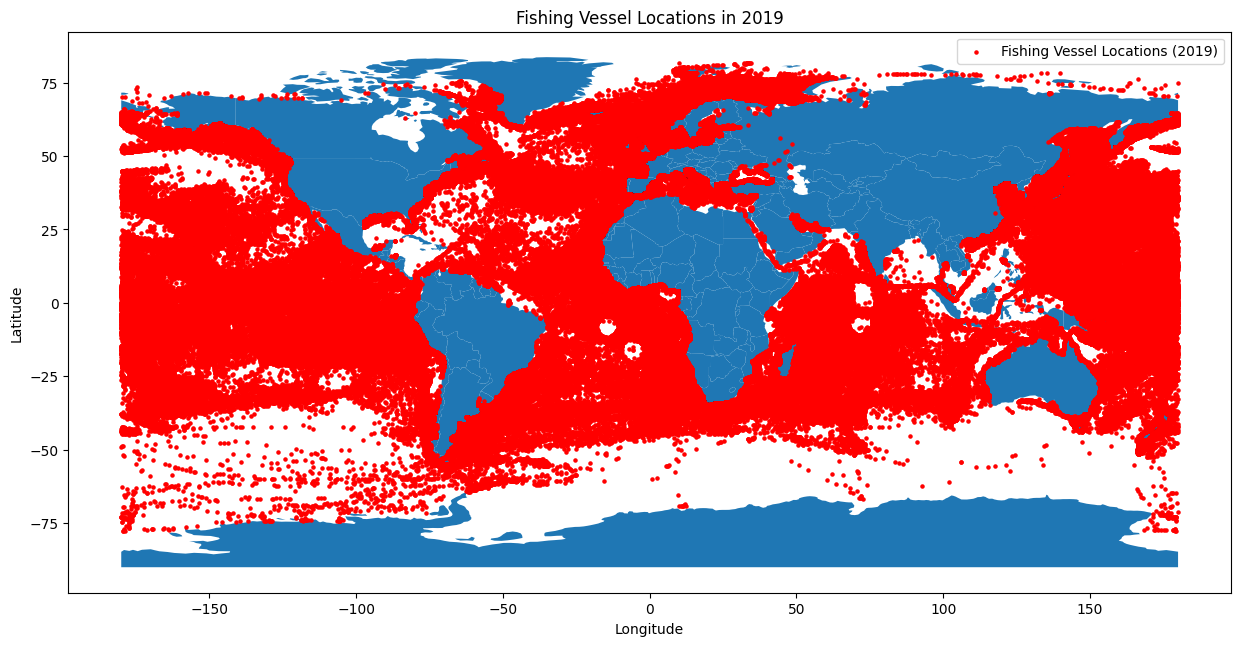

In [32]:
## Sample Data by Year
df['year'] = df['date'].dt.year
unique_years = [2020,2019]

for year in unique_years:
    yearly_df = df[df['year'] == year]
    yearly_df = yearly_df.sample(frac=0.01, random_state = 20)

    ax = world.plot(figsize=(15, 10))
    gdf.plot(ax=ax, marker='o', color='red', markersize=5, label=f'Fishing Vessel Locations ({year})')

    plt.title(f'Fishing Vessel Locations in {year}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

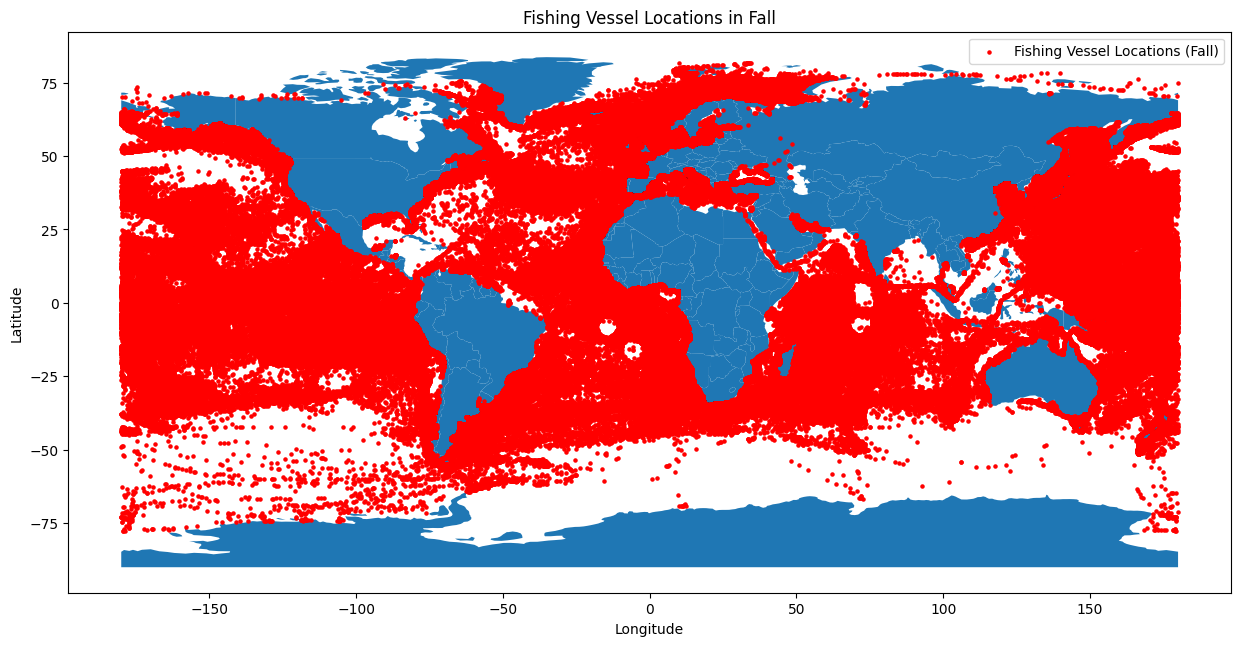

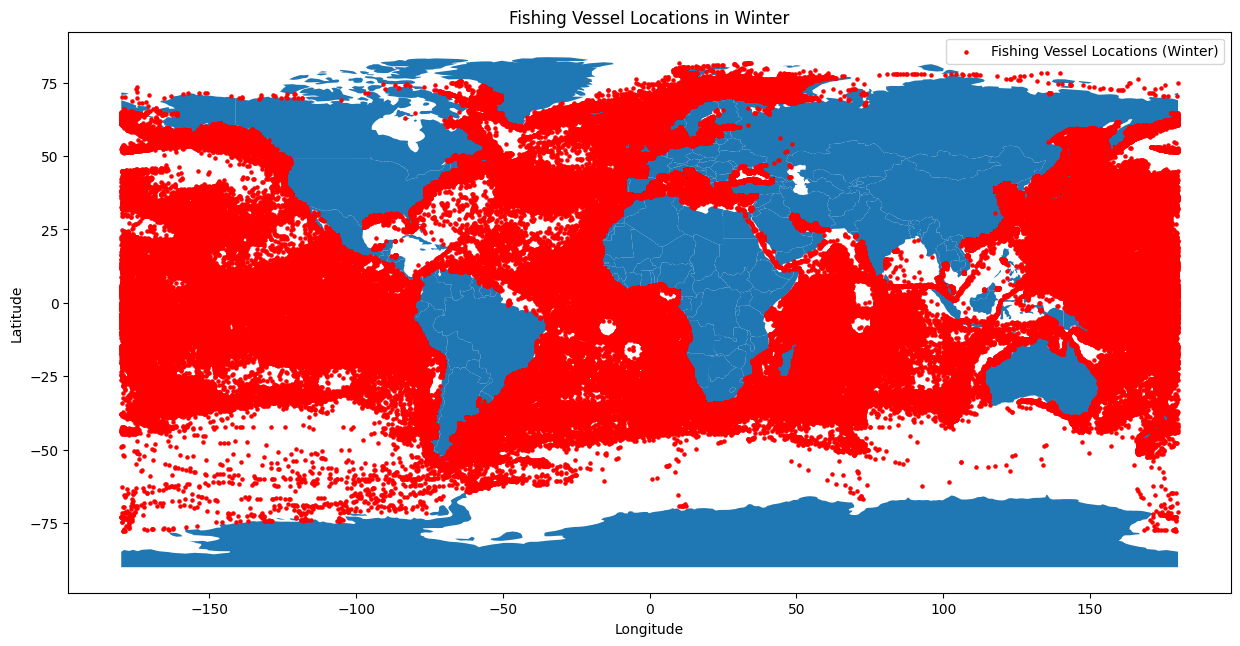

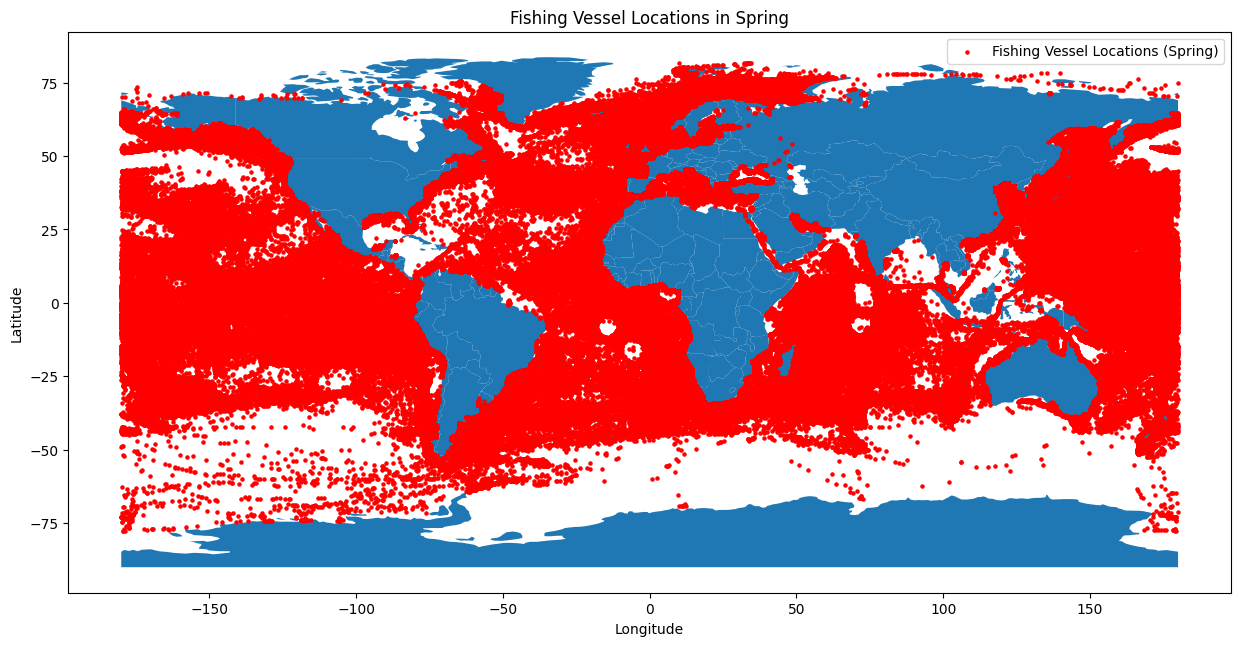

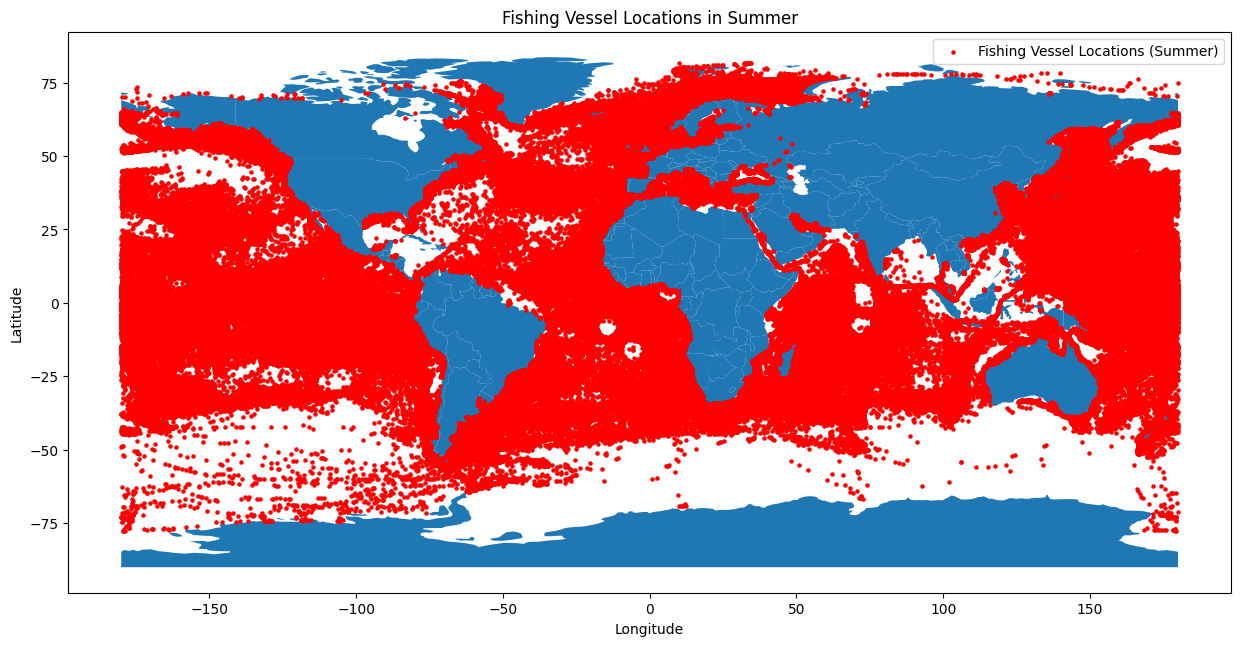

In [33]:
## Sampled Data by Season
seasons_list = ['Fall','Winter','Spring','Summer']

for season in seasons_list:
    season_df = df[df['season'] == season]
    sampled_df = season_df.sample(frac=0.01, random_state = 20)

    ax = world.plot(figsize=(15, 10))
    gdf.plot(ax=ax, marker='o', color='red', markersize=5, label=f'Fishing Vessel Locations ({season})')

    plt.title(f'Fishing Vessel Locations in {season}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()